## Access Mooring Hourly timeseries delayed quality control data in Parquet

A jupyter notebook to show how to access and plot Mooring Hourly timeseries delayed quality control data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "mooring_hourly_timeseries_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 127 packages in 519ms


In [3]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_code: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['WACASO', 'PAPOR']
CPU times: user 7.4 ms, sys: 1.33 ms, total: 8.74 ms
Wall time: 8.23 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

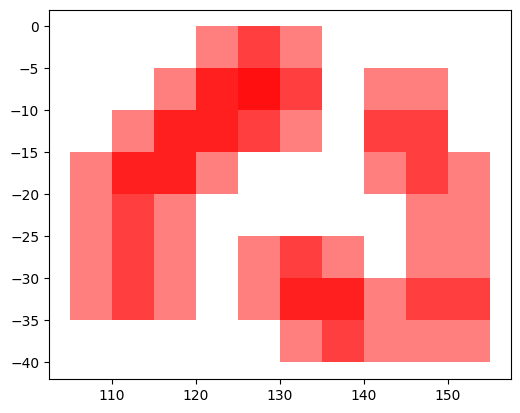

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2007, 7, 1, 10, 0), datetime.datetime(2024, 7, 1, 10, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'instrument_index': {'type': 'int32',
  'long_name': 'which instrument this obs is for',
  'instance_dimension': 'INSTRUMENT'},
 'instrument_id': {'type': 'string',
  'long_name': 'source deployment code, instrument make, model, serial_number'},
 'source_file': {'type': 'string',
  'long_name': 'source file for this instrument',
  'comment': 'This variable lists the relative path of each input file. To obtain a download URL for a file, append its path to the download_url_prefix attribute. To interact with the file remotely via the OPENDAP protocol, append its path to the opendap_url_prefix attribute.',
  'download_url_prefix': 'https://s3-ap-southeast-2.amazonaws.com/imos-data/',
  'opendap_url_prefix': 'http://thredds.aodn.org.au/thredds/dodsC/'},
 'TIME': {'type': 'timestamp[ns]',
  'axis': 'T',
  'comment': 'time stamp corresponds to the hour and represents binned data [30,30) minutes before and after the hour',
  'long_name': 'time',
  'standard_name': 'time',
  'valid_max': 90000

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2021-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-37, lat_max=-34, lon_min=149, lon_max=151)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238806 entries, 0 to 238805
Data columns (total 96 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   instrument_index  238806 non-null  int32         
 1   instrument_id     238806 non-null  object        
 2   source_file       238806 non-null  object        
 3   TIME              238806 non-null  datetime64[ns]
 4   LONGITUDE         238806 non-null  float64       
 5   LATITUDE          238806 non-null  float64       
 6   NOMINAL_DEPTH     238806 non-null  float32       
 7   DEPTH             221997 non-null  float32       
 8   DEPTH_count       238806 non-null  float32       
 9   DEPTH_min         221997 non-null  float32       
 10  DEPTH_max         221997 non-null  float32       
 11  DEPTH_std         221987 non-null  float32       
 12  PRES              112746 non-null  float32       
 13  PRES_REL          34014 non-null   float32       
 14  PRES

In [13]:
print(df["NOMINAL_DEPTH"].unique())
print(df["site_code"].unique())

[ 71.9  20.   44.   52.   28.   13.   36.   60.   68.   69.   53.   61.
  21.   37.   29.   14.   45.   72.9  18.   50.  114.  106.   66.   26.
  74.   58.   82.   42.   90.   34.   98.  117.9  76.  108.   84.  116.
 100.   92.  119.9 116.9  17.  113.   33.   65.   81.  105.   73.   97.
  25.   89.   57.   41.   49. ]
['BMP070', 'BMP120']
Categories (63, object): ['BMP070', 'BMP090', 'BMP120', 'CAM050', ..., 'WATR10', 'WATR15', 'WATR20', 'WATR50']


## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2010-01-01 10:14:00', date_end='2024-02-01 07:50:00')
    
expr_1 = pc.field('site_code') == "BMP070"
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705076 entries, 0 to 705075
Data columns (total 96 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   instrument_index  705076 non-null  int32         
 1   instrument_id     705076 non-null  object        
 2   source_file       705076 non-null  object        
 3   TIME              705076 non-null  datetime64[ns]
 4   LONGITUDE         705076 non-null  float64       
 5   LATITUDE          705076 non-null  float64       
 6   NOMINAL_DEPTH     705076 non-null  float32       
 7   DEPTH             698357 non-null  float32       
 8   DEPTH_count       705076 non-null  float32       
 9   DEPTH_min         698357 non-null  float32       
 10  DEPTH_max         698357 non-null  float32       
 11  DEPTH_std         696028 non-null  float32       
 12  PRES              339205 non-null  float32       
 13  PRES_REL          78222 non-null   float32       
 14  PRES

In [16]:
df = df[df["NOMINAL_DEPTH"] == 52].sort_values('TIME')

<Axes: xlabel='Time', ylabel='Temperature'>

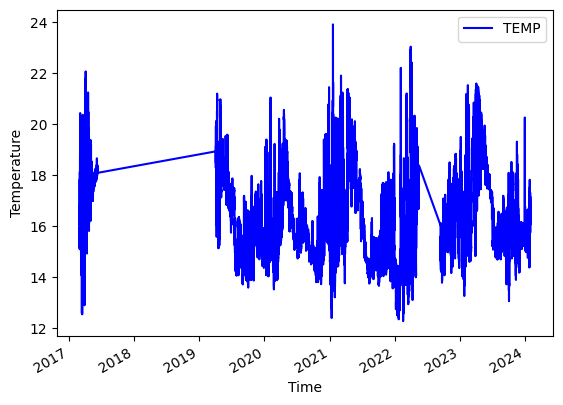

In [17]:
df.plot.line(x='TIME', y='TEMP', label='TEMP', color='blue', ylabel='Temperature', xlabel='Time')